In [1]:
import torch
print(torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [2]:
# import libraires
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# Dataset class for training the gas concentration prediction model
class GasConcentrationDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.feature_maps = []
        self.labels = []
        self.load_data()

    def load_data(self):
        # map folder 
        map_dirs = [os.path.join(self.data_dir, d) for d in os.listdir(self.data_dir) if os.path.isdir(os.path.join(self.data_dir, d))]

        for map_dir in map_dirs:
            feature_map_dir = os.path.join(map_dir, 'feature_map')

            # feature_map folder
            if os.path.exists(feature_map_dir):
                sim_dirs = [os.path.join(feature_map_dir, d) for d in os.listdir(feature_map_dir) if os.path.isdir(os.path.join(feature_map_dir, d))]

                for sim_dir in sim_dirs:
                    try:
                        # load feature map
                        flow_map = np.load(os.path.join(sim_dir, 'flow_definition_map.npy'))
                        sdf_map = np.load(os.path.join(sim_dir, 'sdf_map.npy'))
                        inv_dist_map = np.load(os.path.join(sim_dir, 'inverse_distance_map.npy'))
                        feature_map = np.stack([flow_map, sdf_map, inv_dist_map], axis=0)
                        
                        # load label (gas concentration map)
                        label = np.load(os.path.join(sim_dir, 'gas_concentration_map.npy'))

                        self.feature_maps.append(feature_map)
                        self.labels.append(label)
                    except FileNotFoundError:
                        print(f"Missing data in {sim_dir}, skipping...")
                    except Exception as e:
                        print(f"Error loading data from {sim_dir}: {e}, skipping...")

    def __len__(self):
        return len(self.feature_maps)

    def __getitem__(self, idx):
        feature_map = torch.tensor(self.feature_maps[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return feature_map, label

In [4]:
# load dataset
dataset = GasConcentrationDataset("/home/piai/PABA/gaden/install/test_env/share/test_env/scenarios/2_suc_map")

# Train/Validation Split (90% Train, 10% Validation)
train_size = int(0.9 * len(dataset))
print(train_size)
val_size = len(dataset) - train_size
print(val_size)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# DataLoader 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

Missing data in /home/piai/PABA/gaden/install/test_env/share/test_env/scenarios/2_suc_map/map39/feature_map/sim6, skipping...
Missing data in /home/piai/PABA/gaden/install/test_env/share/test_env/scenarios/2_suc_map/map81/feature_map/sim10, skipping...
Missing data in /home/piai/PABA/gaden/install/test_env/share/test_env/scenarios/2_suc_map/map91/feature_map/sim13, skipping...
Missing data in /home/piai/PABA/gaden/install/test_env/share/test_env/scenarios/2_suc_map/map09/feature_map/sim1, skipping...
1104
123


Feature Map Shape: torch.Size([8, 3, 64, 64])
Label Shape: torch.Size([8, 104, 64])


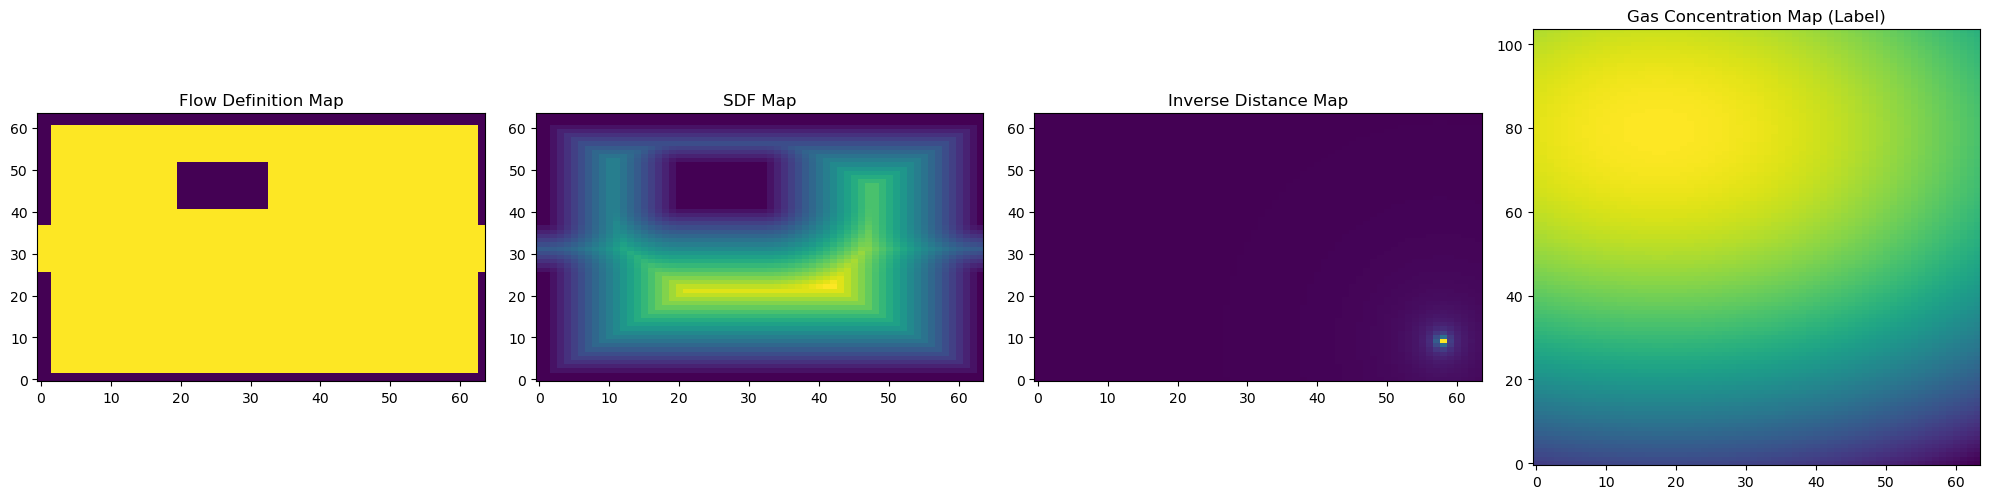

In [5]:
# DataLoader - one batch data 
def check_dataset_loading(loader):
    for feature_maps, labels in loader:
        print("Feature Map Shape:", feature_maps.shape) # (batch_size, 3, 64, 64)
        print("Label Shape:", labels.shape)

        # visualize feature maps and label (1st sample in the batch)
        flow_map = feature_maps[0, 0].cpu().numpy()  # flow_definition_map
        sdf_map = feature_maps[0, 1].cpu().numpy()   # sdf_map
        inv_dist_map = feature_maps[0, 2].cpu().numpy()  # inverse_distance_map
        label_map = labels[0].cpu().numpy()  # gas concentration map (label)

        visualize_maps(flow_map, sdf_map, inv_dist_map, label_map)
        break  
# Map Visualization
def visualize_maps(flow_map, sdf_map, inverse_distance_map, label_map=None):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    # Flow Definition Map
    ax[0].imshow(flow_map, cmap='viridis', origin='lower', aspect=6/10)
    ax[0].set_title('Flow Definition Map')

    # SDF Map
    sdf_plot = ax[1].imshow(sdf_map, cmap='viridis', origin='lower', aspect=6/10)
    ax[1].set_title('SDF Map')

    # Inverse Distance Map
    inv_dist_plot = ax[2].imshow(inverse_distance_map, cmap='viridis', origin='lower', aspect=6/10)
    ax[2].set_title('Inverse Distance Map')

    if label_map is not None:
        label_plot = ax[3].imshow(label_map, cmap='viridis', origin='lower', aspect=6/10)  
        ax[3].set_title('Gas Concentration Map (Label)')

    plt.tight_layout()
    plt.show()

    
check_dataset_loading(train_loader)   

In [20]:
def create_layer(in_channels, out_channels, kernel_size, wn=True, bn=True,
                 activation=nn.ReLU, convolution=nn.Conv2d):
    assert kernel_size % 2 == 1
    layer = []
    conv = convolution(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
    if wn:
        conv = weight_norm(conv)
    layer.append(conv)
    if activation is not None:
        layer.append(activation())
    if bn:
        layer.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layer)

def create_encoder_block(in_channels, out_channels, kernel_size, wn=True, bn=True,
                 activation=nn.ReLU, layers=2):
    encoder = []
    for i in range(layers):
        _in = out_channels
        _out = out_channels
        if i == 0:
            _in = in_channels
        encoder.append(create_layer(_in, _out, kernel_size, wn, bn, activation, nn.Conv2d))
    return nn.Sequential(*encoder)

def create_decoder_block(in_channels, out_channels, kernel_size, wn=True, bn=True,
                 activation=nn.ReLU, layers=2, final_layer=False):
    decoder = []
    for i in range(layers):
        _in = in_channels
        _out = in_channels
        _bn = bn
        _activation = activation
        if i == 0:
            _in = in_channels * 2
        if i == layers - 1:
            _out = out_channels
            if final_layer:
                _bn = False
                _activation = None
        decoder.append(create_layer(_in, _out, kernel_size, wn, _bn, _activation, nn.ConvTranspose2d))
    return nn.Sequential(*decoder)

def create_encoder(in_channels, filters, kernel_size, wn=True, bn=True, activation=nn.ReLU, layers=2):
    encoder = []
    for i in range(len(filters)):
        if i == 0:
            encoder_layer = create_encoder_block(in_channels, filters[i], kernel_size, wn, bn, activation, layers)
        else:
            encoder_layer = create_encoder_block(filters[i-1], filters[i], kernel_size, wn, bn, activation, layers)
        encoder = encoder + [encoder_layer]
    return nn.Sequential(*encoder)

def create_decoder(out_channels, filters, kernel_size, wn=True, bn=True, activation=nn.ReLU, layers=2):
    decoder = []
    for i in range(len(filters)):
        if i == 0:
            decoder_layer = create_decoder_block(filters[i], out_channels, kernel_size, wn, bn, activation, layers, final_layer=True)
        else:
            decoder_layer = create_decoder_block(filters[i], filters[i-1], kernel_size, wn, bn, activation, layers, final_layer=False)
        decoder = [decoder_layer] + decoder
    return nn.Sequential(*decoder)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, filters=[16, 32, 64], layers=2,
                 weight_norm=True, batch_norm=True, activation=nn.ReLU, final_activation=None):
        super().__init__()
        assert len(filters) > 0
        self.final_activation = final_activation
        self.encoder = create_encoder(in_channels, filters, kernel_size, weight_norm, batch_norm, activation, layers)
        self.decoder = create_decoder(out_channels, filters, kernel_size, weight_norm, batch_norm, activation, layers)

    def encode(self, x):
        tensors = []
        indices = []
        sizes = []
        for encoder in self.encoder:
            x = encoder(x)
            sizes.append(x.size())
            tensors.append(x)
            x, ind = F.max_pool2d(x, 2, 2, return_indices=True)
            indices.append(ind)
        return x, tensors, indices, sizes

    def decode(self, x, tensors, indices, sizes):
        for decoder in self.decoder:
            tensor = tensors.pop()
            size = sizes.pop()
            ind = indices.pop()
            x = F.max_unpool2d(x, ind, 2, 2, output_size=size)
            x = torch.cat([tensor, x], dim=1)
            x = decoder(x)
        return x

    def forward(self, x):
        x, tensors, indices, sizes = self.encode(x)
        x = self.decode(x, tensors, indices, sizes)

        # 업샘플링: 출력 크기를 104x64로 변경
        x = F.interpolate(x, size=(104, 64), mode='bilinear', align_corners=False)

        if self.final_activation is not None:
            x = self.final_activation(x)
        return x

In [21]:
# Model train and validation with early stopping and progress bar
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1000, model_path='best_model.pth', patience=10):
    best_val_loss = float('inf')  # Initialize with a very large value
    train_losses = []
    val_losses = []
    epochs_without_improvement = 0  # Count how many epochs since last improvement

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        # Progress bar for training
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                # Track loss
                running_loss += loss.item()
                pbar.set_postfix({'Train Loss': running_loss / (pbar.n + 1)})
                pbar.update(1)
                
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Check if validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
            print(f'Epoch {epoch+1}: Validation loss improved to {val_loss:.4f}, model saved as {model_path}')
            epochs_without_improvement = 0  # Reset the counter if validation improves
        else:
            epochs_without_improvement += 1
            print(f'Epoch {epoch+1}: No improvement in validation loss. {epochs_without_improvement} epochs without improvement.')

        # Check early stopping condition
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}. No improvement in {patience} consecutive epochs.")
            break

        # Epoch logging every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')
    
    return train_losses, val_losses

# Loss visualization
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

In [33]:
# Hyperparameters
kernel_size=5
filters=[8, 16, 32, 32]
lr=0.001
weight_decay=0.005
in_channels=3
out_channels=1

num_epochs=100
patience=3


# model initialization
model = UNet(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, 
             filters=filters).to(device)

# loss function and optimizer
criterion = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# model trainig
train_losses, val_losses = train_model(model, train_loader, val_loader, 
                                        criterion, optimizer, num_epochs=num_epochs, patience=patience)

Epoch 1/100: 100%|██████████| 138/138 [00:03<00:00, 39.70batch/s, Train Loss=0.065] 


Epoch 1: Validation loss improved to 0.0075, model saved as best_model.pth


Epoch 2/100: 100%|██████████| 138/138 [00:03<00:00, 38.78batch/s, Train Loss=0.00476]


Epoch 2: Validation loss improved to 0.0029, model saved as best_model.pth


Epoch 3/100: 100%|██████████| 138/138 [00:03<00:00, 39.25batch/s, Train Loss=0.00229]


Epoch 3: Validation loss improved to 0.0017, model saved as best_model.pth


Epoch 4/100: 100%|██████████| 138/138 [00:03<00:00, 38.91batch/s, Train Loss=0.0014] 


Epoch 4: Validation loss improved to 0.0011, model saved as best_model.pth


Epoch 5/100: 100%|██████████| 138/138 [00:03<00:00, 39.51batch/s, Train Loss=0.00105]


Epoch 5: Validation loss improved to 0.0008, model saved as best_model.pth


Epoch 6/100: 100%|██████████| 138/138 [00:03<00:00, 38.74batch/s, Train Loss=0.000757]


Epoch 6: Validation loss improved to 0.0006, model saved as best_model.pth


Epoch 7/100: 100%|██████████| 138/138 [00:03<00:00, 38.18batch/s, Train Loss=0.000662]


Epoch 7: Validation loss improved to 0.0006, model saved as best_model.pth


Epoch 8/100: 100%|██████████| 138/138 [00:03<00:00, 38.85batch/s, Train Loss=0.000554]


Epoch 8: Validation loss improved to 0.0004, model saved as best_model.pth


Epoch 9/100: 100%|██████████| 138/138 [00:03<00:00, 38.47batch/s, Train Loss=0.000435]


Epoch 9: No improvement in validation loss. 1 epochs without improvement.


Epoch 10/100: 100%|██████████| 138/138 [00:03<00:00, 38.81batch/s, Train Loss=0.000379]


Epoch 10: Validation loss improved to 0.0003, model saved as best_model.pth


Epoch 11/100: 100%|██████████| 138/138 [00:03<00:00, 38.48batch/s, Train Loss=0.000331]


Epoch 11: Validation loss improved to 0.0003, model saved as best_model.pth


Epoch 12/100: 100%|██████████| 138/138 [00:03<00:00, 38.67batch/s, Train Loss=0.000286]


Epoch 12: Validation loss improved to 0.0002, model saved as best_model.pth


Epoch 13/100: 100%|██████████| 138/138 [00:03<00:00, 39.32batch/s, Train Loss=0.000254]


Epoch 13: Validation loss improved to 0.0002, model saved as best_model.pth


Epoch 14/100: 100%|██████████| 138/138 [00:03<00:00, 40.15batch/s, Train Loss=0.000216]


Epoch 14: Validation loss improved to 0.0002, model saved as best_model.pth


Epoch 15/100: 100%|██████████| 138/138 [00:03<00:00, 37.50batch/s, Train Loss=0.000203]


Epoch 15: No improvement in validation loss. 1 epochs without improvement.


Epoch 16/100: 100%|██████████| 138/138 [00:03<00:00, 38.94batch/s, Train Loss=0.000199]


Epoch 16: Validation loss improved to 0.0001, model saved as best_model.pth


Epoch 17/100: 100%|██████████| 138/138 [00:03<00:00, 38.00batch/s, Train Loss=0.000176]


Epoch 17: Validation loss improved to 0.0001, model saved as best_model.pth


Epoch 18/100: 100%|██████████| 138/138 [00:03<00:00, 38.54batch/s, Train Loss=0.000166]


Epoch 18: No improvement in validation loss. 1 epochs without improvement.


Epoch 19/100: 100%|██████████| 138/138 [00:03<00:00, 39.03batch/s, Train Loss=0.000141]


Epoch 19: No improvement in validation loss. 2 epochs without improvement.


Epoch 20/100: 100%|██████████| 138/138 [00:03<00:00, 38.16batch/s, Train Loss=0.000121]


Epoch 20: Validation loss improved to 0.0001, model saved as best_model.pth


Epoch 21/100: 100%|██████████| 138/138 [00:03<00:00, 38.05batch/s, Train Loss=0.000128]


Epoch 21: Validation loss improved to 0.0001, model saved as best_model.pth


Epoch 22/100: 100%|██████████| 138/138 [00:03<00:00, 40.07batch/s, Train Loss=0.000119]


Epoch 22: Validation loss improved to 0.0001, model saved as best_model.pth


Epoch 23/100: 100%|██████████| 138/138 [00:03<00:00, 37.92batch/s, Train Loss=0.000108]


Epoch 23: Validation loss improved to 0.0001, model saved as best_model.pth


Epoch 24/100: 100%|██████████| 138/138 [00:02<00:00, 46.09batch/s, Train Loss=9.89e-5]


Epoch 24: No improvement in validation loss. 1 epochs without improvement.


Epoch 25/100: 100%|██████████| 138/138 [00:03<00:00, 41.11batch/s, Train Loss=9.53e-5]


Epoch 25: Validation loss improved to 0.0001, model saved as best_model.pth


Epoch 26/100: 100%|██████████| 138/138 [00:03<00:00, 37.23batch/s, Train Loss=9.04e-5]


Epoch 26: No improvement in validation loss. 1 epochs without improvement.


Epoch 27/100: 100%|██████████| 138/138 [00:03<00:00, 37.34batch/s, Train Loss=8.44e-5]


Epoch 27: No improvement in validation loss. 2 epochs without improvement.


Epoch 28/100: 100%|██████████| 138/138 [00:03<00:00, 37.97batch/s, Train Loss=7.82e-5]


Epoch 28: No improvement in validation loss. 3 epochs without improvement.
Early stopping at epoch 28. No improvement in 3 consecutive epochs.


In [34]:
# import optuna

# # Hyperparameter optimization objective function
# def objective(trial):
#     # Define hyperparameters to tune
#     kernel_size = trial.suggest_categorical('kernel_size', [3, 5])
#     filters = [trial.suggest_int(f'filters_{i}', 4, 64) for i in range(4)]
#     lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
#     weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)

#     # Model initialization
#     model = UNet(in_channels=3, out_channels=1, kernel_size=kernel_size, filters=filters).to(device)

#     # Loss function and optimizer
#     criterion = nn.MSELoss()
#     optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

#     # Train the model (this function should return validation loss)
#     train_losses, val_losses = train_model(model, train_loader, val_loader, 
#                                             criterion, optimizer, num_epochs=1000, patience=10)

#     # Return the final validation loss for Optuna to minimize
#     return val_losses[-1]  # 마지막 검증 손실 반환

# # Create a study and optimize
# study = optuna.create_study(direction='minimize')  # minimize the validation loss
# study.optimize(objective, n_trials=100)  # try 100 different hyperparameters


# print("Best hyperparameters: ", study.best_params)

# # model train with best hyperparameters
# best_params = study.best_params
# final_model = UNet(in_channels=3, out_channels=1, kernel_size=best_params['kernel_size'], 
#                    filters=best_params['filters']).to(device)

# final_criterion = nn.MSELoss()
# final_optimizer = optim.AdamW(final_model.parameters(), lr=best_params['lr'], 
#                                weight_decay=best_params['weight_decay'])

# # final model training
# final_train_losses, final_val_losses = train_model(final_model, train_loader, val_loader, 
#                                                     final_criterion, final_optimizer, 
#                                                     num_epochs=1000, patience=10)

# print("Final training losses: ", final_train_losses)
# print("Final validation losses: ", final_val_losses)

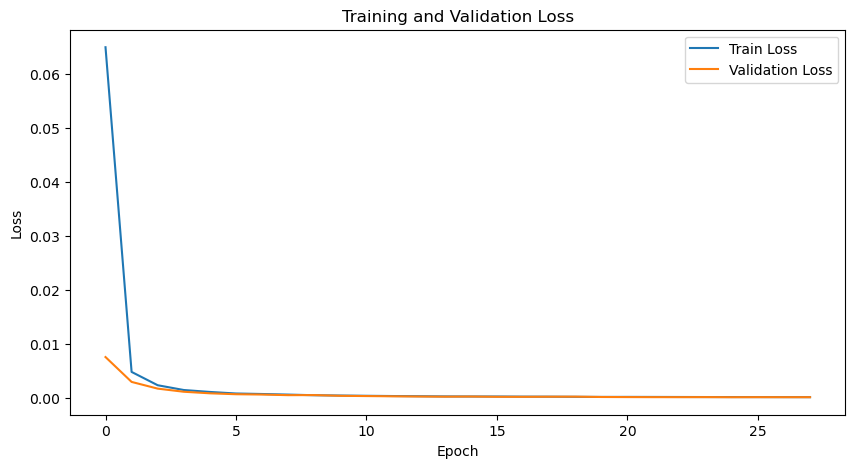

In [35]:
plot_losses(train_losses, val_losses)

Sample 1:


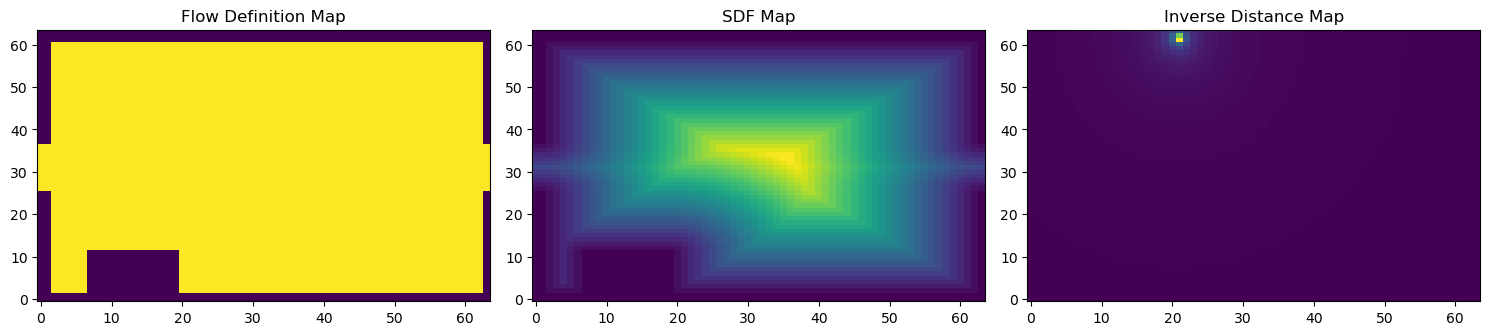

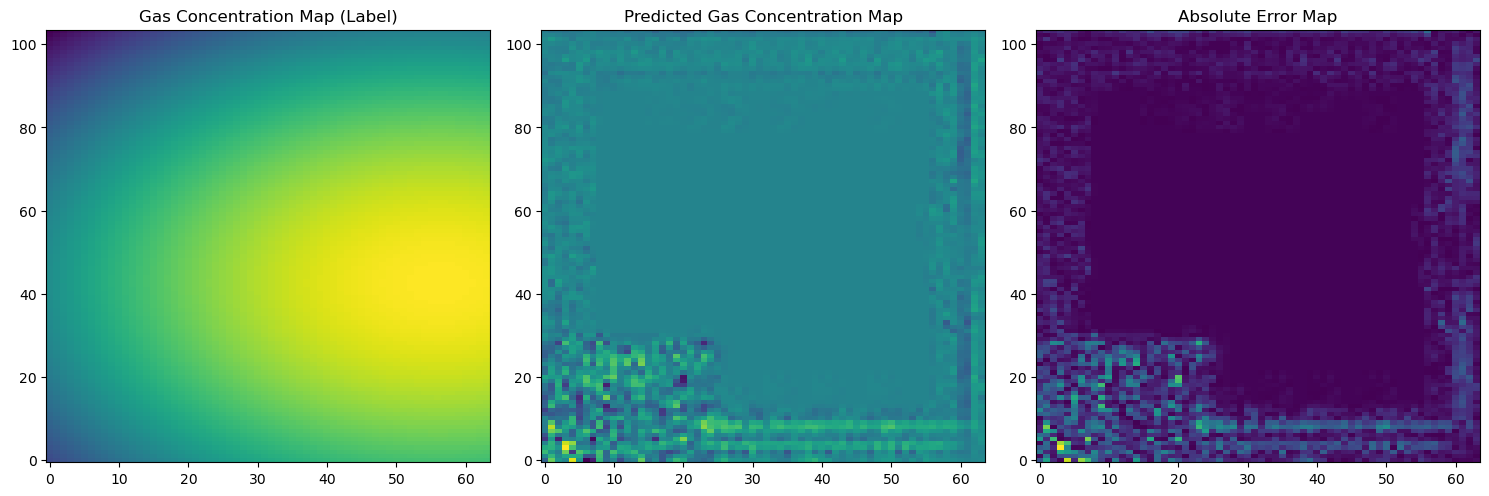

Sample 2:


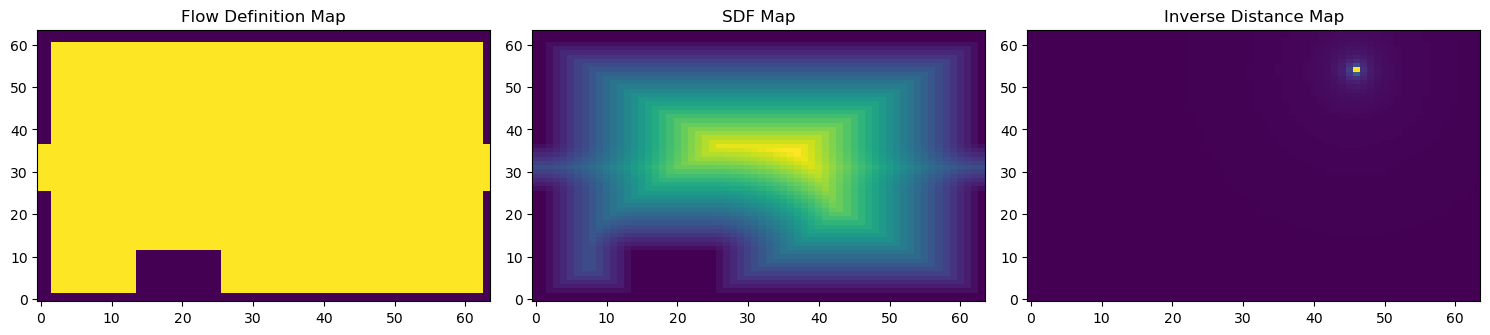

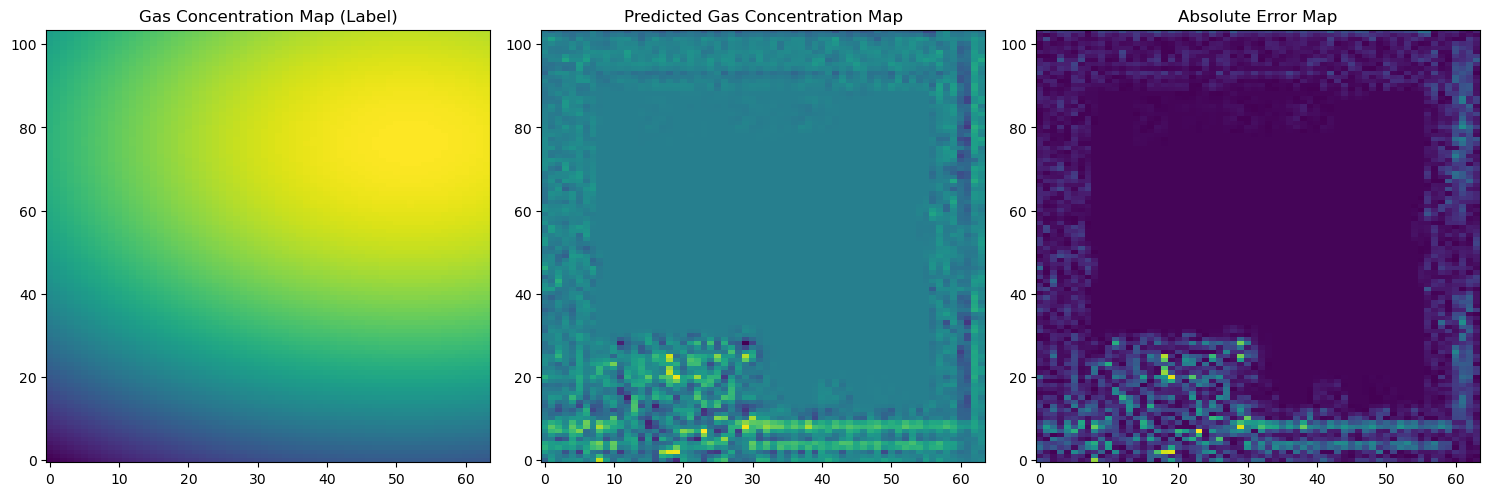

Sample 3:


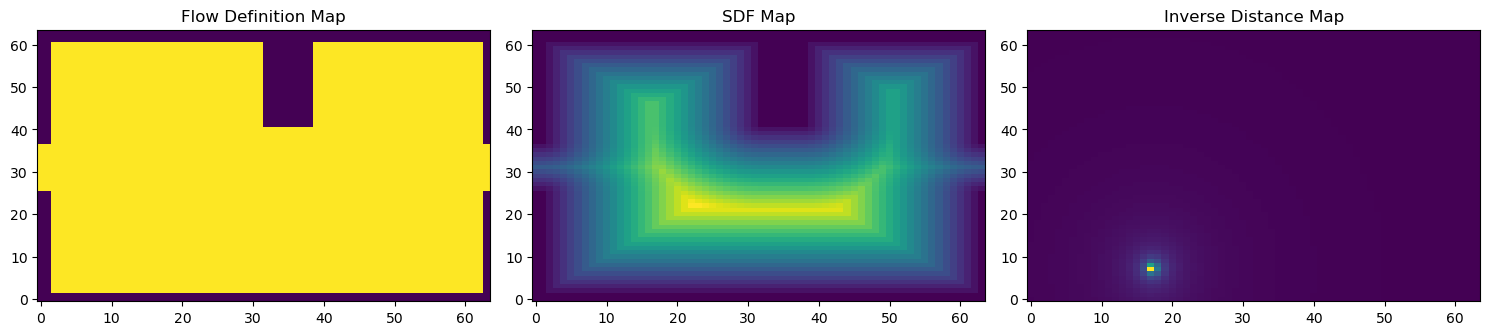

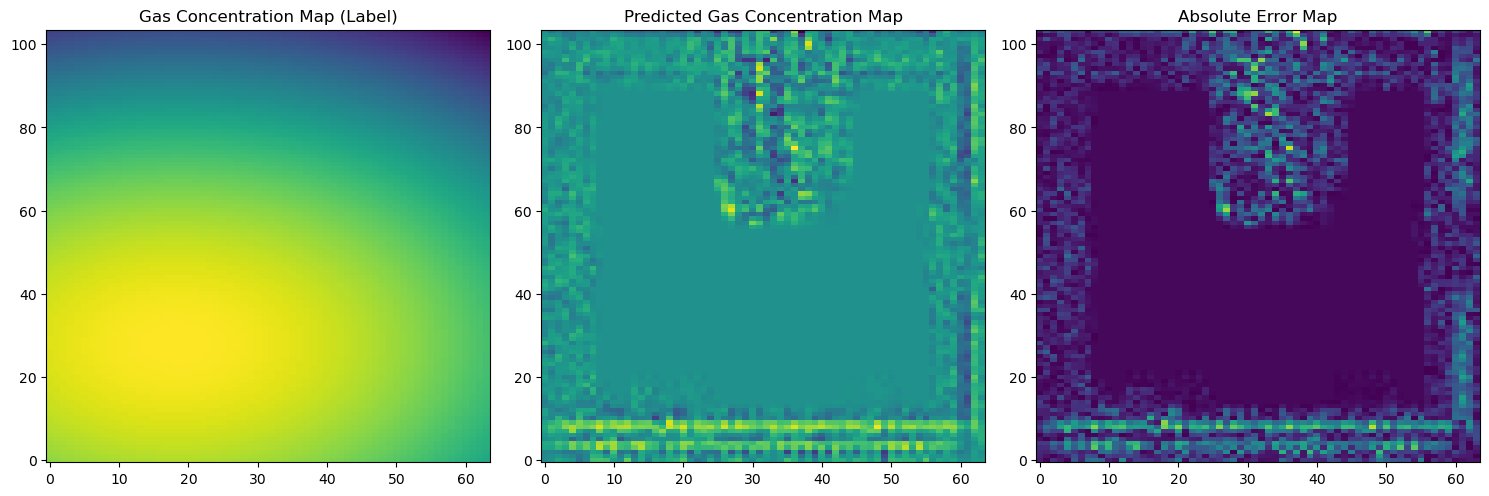

In [37]:
# Visualize prediction and label with absolute error
def visualize_feature_maps(flow_map, sdf_map, inverse_distance_map):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Flow Definition Map
    ax[0].imshow(flow_map, cmap='viridis', origin='lower', aspect=6/10)
    ax[0].set_title('Flow Definition Map')

    # SDF Map
    ax[1].imshow(sdf_map, cmap='viridis', origin='lower', aspect=6/10)
    ax[1].set_title('SDF Map')

    # Inverse Distance Map
    ax[2].imshow(inverse_distance_map, cmap='viridis', origin='lower', aspect=6/10)
    ax[2].set_title('Inverse Distance Map')
 
    plt.tight_layout()
    plt.show()
    
def visualize_prediction_and_label(label_map, pred_map):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Real gas concentration map
    label_map = label_map.squeeze()  # (1, 104, 64) -> (104, 64)
    ax[0].imshow(label_map, cmap='viridis', origin='lower', aspect=6/10)
    ax[0].set_title('Gas Concentration Map (Label)')

    # Predicted gas concentration map
    pred_map = pred_map.squeeze()  # (1, 104, 64) -> (104, 64)
    ax[1].imshow(pred_map, cmap='viridis', origin='lower', aspect=6/10)
    ax[1].set_title('Predicted Gas Concentration Map')

    # Absolute error map
    abs_error_map = np.abs(label_map - pred_map)
    ax[2].imshow(abs_error_map, cmap='viridis', origin='lower', aspect=6/10)
    ax[2].set_title('Absolute Error Map')

    plt.tight_layout()
    plt.show()

# Compare model prediction with label
def visualize_prediction(model, loader, num_samples=1):
    model.eval()
    with torch.no_grad():
        for i, (feature_maps, labels) in enumerate(loader):
            feature_maps, labels = feature_maps.to(device), labels.to(device)

            # Model prediction
            predictions = model(feature_maps)

            # Visualization - one batch data 
            for sample in range(num_samples):
                flow_map = feature_maps[sample, 0].cpu().numpy()
                sdf_map = feature_maps[sample, 1].cpu().numpy()
                inv_dist_map = feature_maps[sample, 2].cpu().numpy()
                label_map = labels[sample].cpu().numpy()
                pred_map = predictions[sample].cpu().numpy()

                print(f"Sample {sample+1}:")

                visualize_feature_maps(flow_map, sdf_map, inv_dist_map)
                visualize_prediction_and_label(label_map, pred_map)
            break  
        
visualize_prediction(model, val_loader, num_samples=3)